In [1]:
import os;
import sys;
import random;
import math
import json
import imutils;

import numpy as np;
import cv2;
import matplotlib.pyplot as plt;

from skimage.feature import greycomatrix, greycoprops,local_binary_pattern


import tensorflow as tf
from tensorflow import keras;

from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import roc_curve, auc

from keras import backend as K


import mahotas as mt
import sklearn

from skimage.filters import gabor



from sklearn.manifold import TSNE

from mpl_toolkits.mplot3d import Axes3D 


import umap
import phate

from pywt import dwt2

import csv


/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/dlenv3/lib/python3.6/site-packages/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
mapfile="/home/ubuntu/project/pythologyImageDL/scatterplot/data/new_gland_tsne32.csv"

In [3]:
data=[]
with open(mapfile) as f:
    f2 =csv.reader(f)
    data=list(f2)

data=np.asarray(data)

In [5]:
colors=[];
for i in data:
    if i[1] =="normal":
        colors.append("green")
    elif i[1] =="treatment":
        colors.append("blue")
    elif i[1] =="dss":
        colors.append("red")
        
    else:
        print(i)

In [6]:
x=[float(i) for i in data[:, 2]];
y=[float(i) for i in data[:,3]];




/home/ubuntu/dlenv3/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


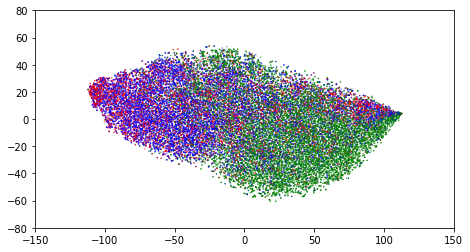

In [274]:
fig= plt.figure(figsize=(7.5,4))
plt.xlim([-150,150])
plt.ylim([-80,80])

ax = fig.add_subplot(111)
ax.scatter(x, y,c=colors,s=0.1)

In [10]:
import seaborn as sns

In [74]:
dssx = []
dssy = []
dssid=[];

normalx = []
normaly = []
normalid=[];



treatx = []
treaty = []
treatid=[];


for i in data:
    if i[1] =="normal":
        normalx.append(float(i[2]))
        normaly.append(float(i[3]))
        normalid.append(i[0])
        
    elif i[1] =="treatment":
        treatx.append(float(i[2]))
        treaty.append(float(i[3]))
        treatid.append(i[0])
    elif i[1] =="dss":
        dssx.append(float(i[2]))
        dssy.append(float(i[3]))
        dssid.append(i[0])
        
    else:
        print(i)
    


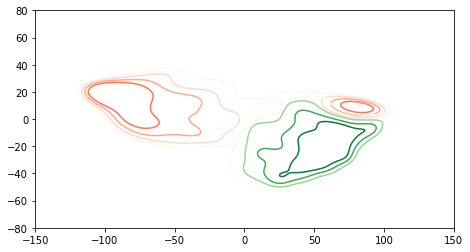

In [508]:

fig = plt.figure(figsize=(7.5, 4))

sns.kdeplot(x=dssx, y=dssy, levels=5,cmap="Reds",thresh=0.4)
sns.kdeplot(x=normalx, y=normaly, levels=5,cmap="Greens",thresh=0.4)

plt.xlim([-150,150])
plt.ylim([-80,80])


plt.show()

In [510]:
# I score each level of contour. dissease is -4,-3,-2,-1,0   control is 0,1,2,3,4  
#we observe all the node location from treatment. and get the score of node(each gland).

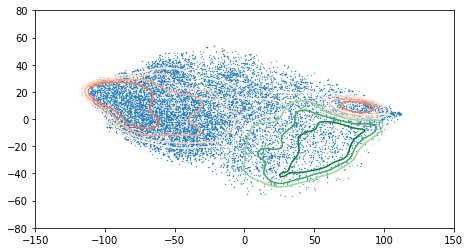

In [509]:

fig = plt.figure(figsize=(7.5, 4))

sns.kdeplot(x=dssx, y=dssy, levels=5,cmap="Reds",thresh=0.4)
sns.kdeplot(x=normalx, y=normaly, levels=5,cmap="Greens",thresh=0.4)

plt.xlim([-150,150])
plt.ylim([-80,80])

plt.scatter(treatx, treaty,s=0.1)

plt.show()

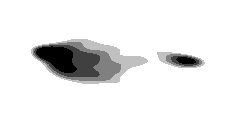

In [511]:
fig= plt.figure(figsize=(7.5/1.8,4/1.8))
sns.kdeplot(x=dssx, y=dssy, levels=5 ,thresh=0.4,fill=True,colors=["#C0C0C0", "#808080", "#404040","#000000"])

plt.xlim([-150,150])
plt.ylim([-80,80])

plt.axis('off')


plt.savefig("dss_contour.png",pad_inches=0)

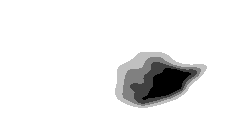

In [513]:
fig= plt.figure(figsize=(7.5/1.8,4/1.8))


sns.kdeplot(x=normalx, y=normaly, levels=5 ,thresh=0.4,fill=True,colors=["#C0C0C0", "#808080", "#404040","#000000"])

plt.xlim([-150,150])
plt.ylim([-80,80])

plt.axis('off')

plt.savefig("normal_contour.png",pad_inches=0)

In [514]:
nc = cv2.imread("normal_contour.png",cv2.IMREAD_GRAYSCALE)

In [515]:
nc.shape

(160, 300)

In [516]:
dc = cv2.imread("dss_contour.png",cv2.IMREAD_GRAYSCALE)

In [517]:
dc.shape

(160, 300)

In [518]:
dss_score=[];
control_score=[];
eval_score=[];
for i in range(len(treatid)):
    dsscolor=dc[round(treaty[i]) +80  ][round(treatx[i]) +150 ]
    dss_score.append(4-round(dsscolor/64))
    
    
    controlcolor=nc[round(treaty[i]) +80  ][round(treatx[i]) +150 ]
    control_score.append(4-round(controlcolor/64))
    eval_score.append(control_score[i]-dss_score[i])

In [519]:
score2=[x*-1 for x in eval_score]

In [520]:
score3=[ ]
for x in score2:
    if x <=0:
        score3.append(0)
    else:
        score3.append(x)

In [521]:
result=dict()
for i in treatid:
    result[i.split("___")[0]]={"dss_score":[],"combine_score":[]};
    
for i in range(len(treatid)):
    result[treatid[i].split("___")[0]]["dss_score"].append(dss_score[i]);    
    result[treatid[i].split("___")[0]]["combine_score"].append(score3[i]);  

In [522]:
for i in result:
    result[i]['dss_score']=np.mean(result[i]['dss_score'])
    result[i]['combine_score']=np.mean(result[i]['combine_score'])

In [524]:
#score method 2

In [540]:
slidedata=dict();

ids32 = data[:,0]
for i in range(len(ids32)):
    name = ids32[i].split("___")[0];
    slidedata[name]={"color":colors[i],"umap":[],"phate":[],"tsne":[]};
    
for i in range(len(ids32)):
    name = ids32[i].split("___")[0];
    
    coor =[float(data[i][2]),float(data[i][ 3])];
    slidedata[name]["tsne"].append(coor);
    
for i in slidedata:
    
    coors = slidedata[i]["tsne"];
    xs=[];
    ys=[];
    for c in coors:
        xs.append(c[0])
        ys.append(c[1])
    
    mean = np.mean(xs);
    std = np.std(xs)
    xs = [x for x in xs if (x > mean - 2 * std)]
    xs = [x for x in xs if (x < mean + 2 * std)]
    
    mean = np.mean(ys);
    std = np.std(ys)
    ys = [x for x in ys if (x > mean - 2 * std)]
    ys = [x for x in ys if (x < mean + 2 * std)]
        
    xs = sum(xs)/len(xs)
    ys = sum(ys)/len(ys)
    
    slidedata[i]["tsne"]=(xs,ys);

In [542]:
slidecolors=[];

slidetsne=[];
slideid=[]
for i in slidedata:
    slidecolors.append(slidedata[i]["color"]);
    
    slidetsne.append(list(slidedata[i]["tsne"]));
    slideid.append(i)

slidetsne=np.asarray(slidetsne)

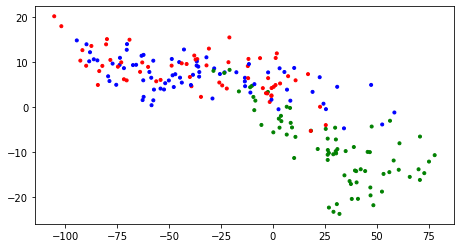

In [543]:
fig = plt.figure(figsize=(7.5, 4))

ax = fig.add_subplot(111)

ax.scatter(slidetsne[:, 0], slidetsne[:, 1],c=slidecolors,s=9)

In [614]:
scoredata=[]
with open("dss32_slidelevel_v4.csv") as f:
    f2 =csv.reader(f)
    scoredata=list(f2)

scoredata=np.asarray(scoredata)

In [639]:
keyvalue=dict();
for i in scoredata[1:]:
    keyvalue[i[0]]=int( float(i[-3]))
    
scorecolor=["green","steelblue","blue","orange","red"]

In [640]:
scorecolors=[];
for i in slideid:
    if i in keyvalue:
        val=keyvalue[ i]
        scorecolors.append(scorecolor[val])
    else:
        scorecolors.append("gray")

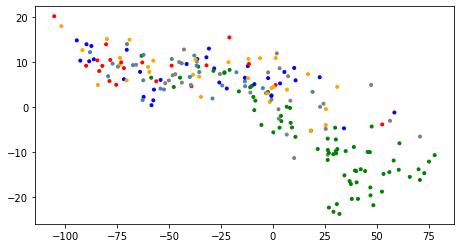

In [641]:
fig = plt.figure(figsize=(7.5, 4))

ax = fig.add_subplot(111)

ax.scatter(slidetsne[:, 0], slidetsne[:, 1],c=scorecolors,s=9)

In [544]:
dssdict={"treatment":set(),"dss":set(),"normal":set()};
for i in range(len(slideid)):
    if slidecolors[i] == "blue":
        dssdict["treatment"].add(slideid[i].split("_")[0])
        
    if slidecolors[i] == "red":
        dssdict["dss"].add(slideid[i].split("_")[0])
        
    if slidecolors[i] == "green":
        dssdict["normal"].add(slideid[i].split("_")[0])

In [546]:
for i in dssdict:
    dssdict[i]=list(dssdict[i])
    dssdict[i].sort()

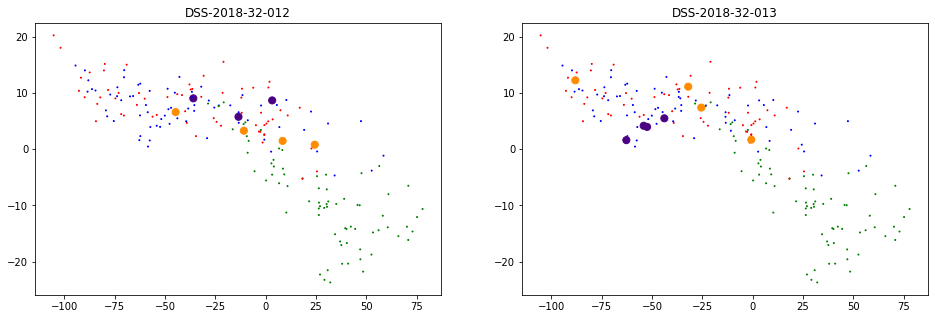

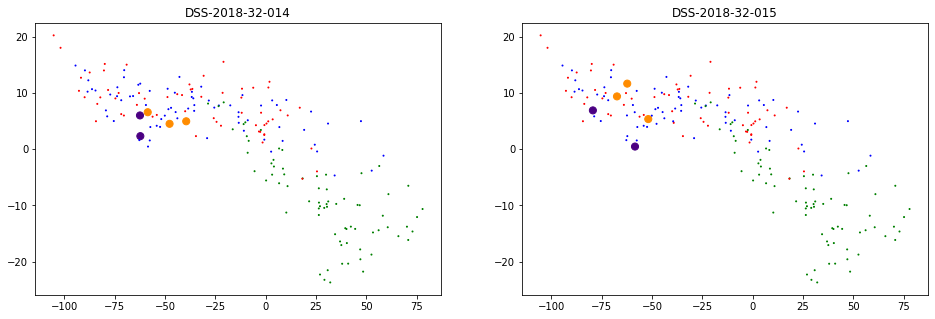

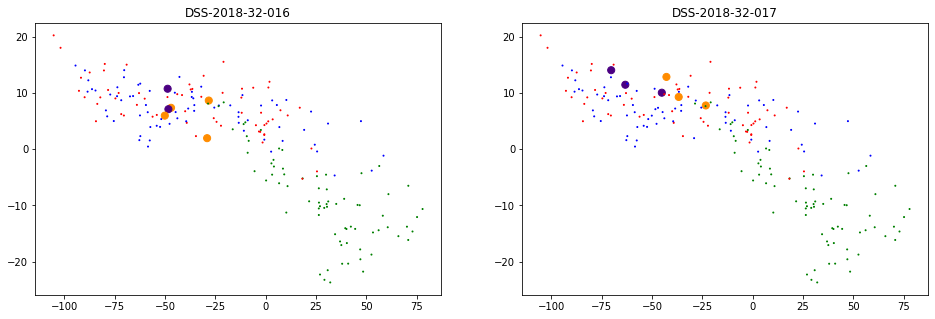

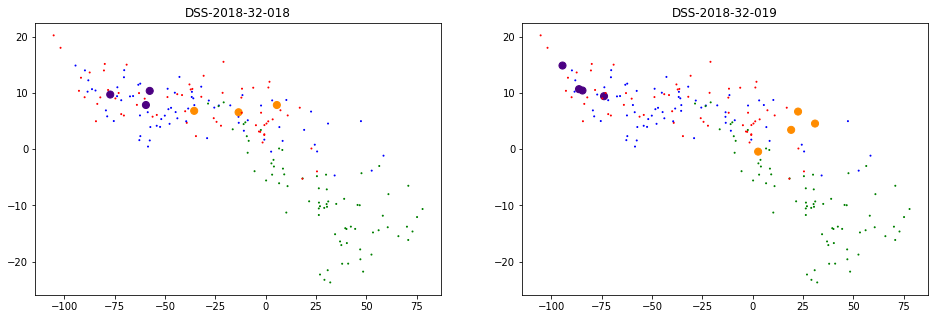

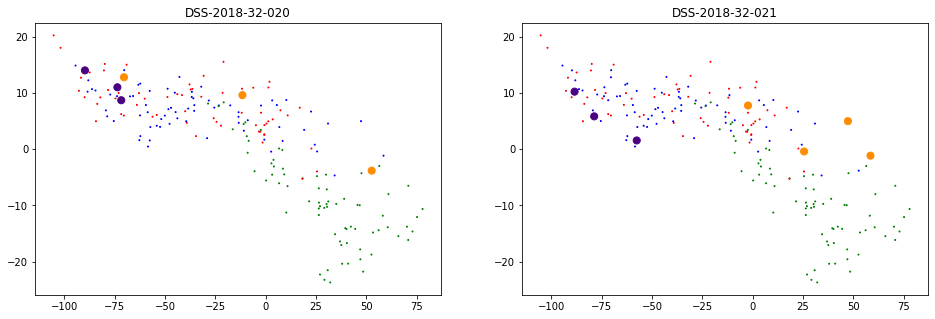

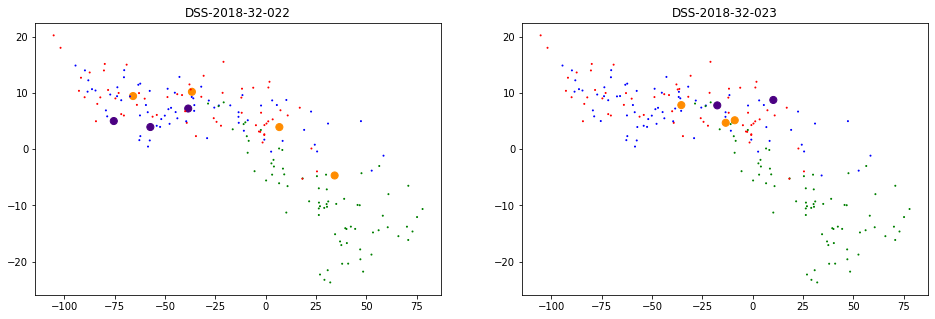

In [547]:
pltindex=1;

for i in dssdict["treatment"]:
    sizelist=[];
    newcolors=[];
    
    for index in range(len(slideid)):
        
        
        if slideid[index].startswith(i+"_"):
            sizelist.append(50)
            
            location = slideid[index].split("_")[1];
            location=location[0];
            if location == "a":
                newcolors.append("indigo")
            elif location == "b":
                newcolors.append("darkorange")
        else:
            sizelist.append(1)
            newcolors.append(slidecolors[index])
    if pltindex==1:
        fig = plt.figure(figsize=(16, 5))
    ax = fig.add_subplot(120+pltindex)
    
    ax.set_title(i)
    
    ax.scatter(slidetsne[:, 0], slidetsne[:, 1],c=newcolors,s=sizelist)
    
    
    
    pltindex+=1;
    
    if pltindex>2:
        pltindex=1;

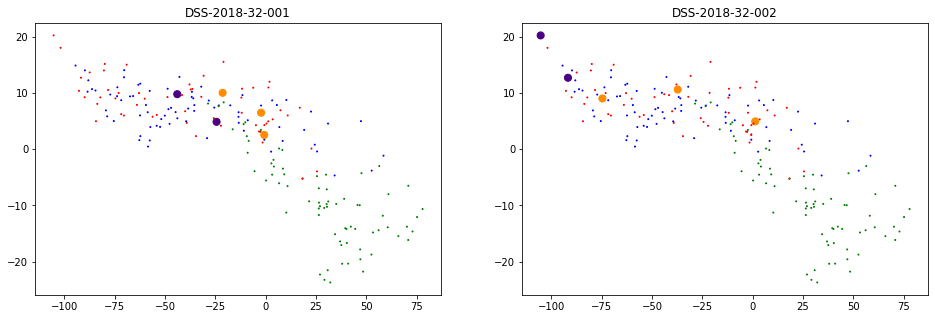

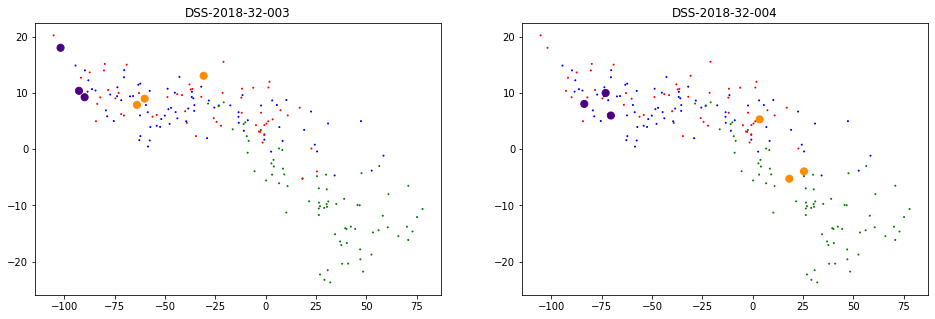

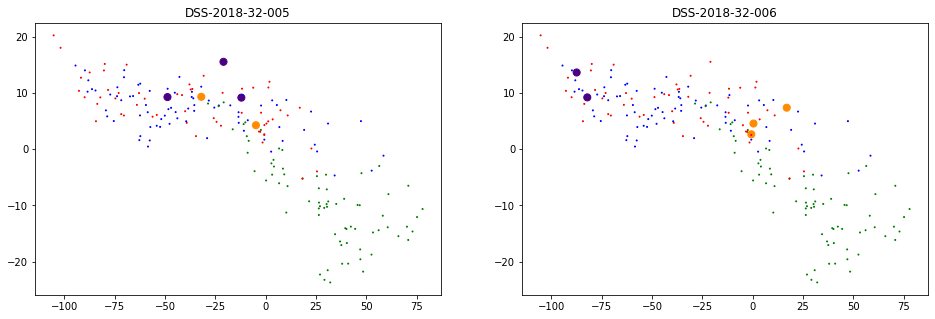

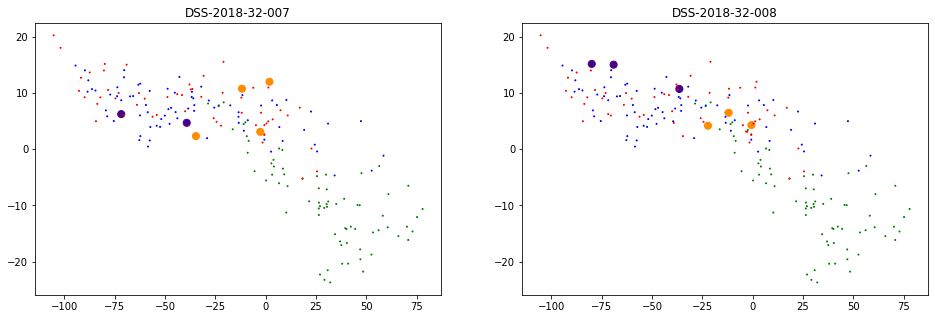

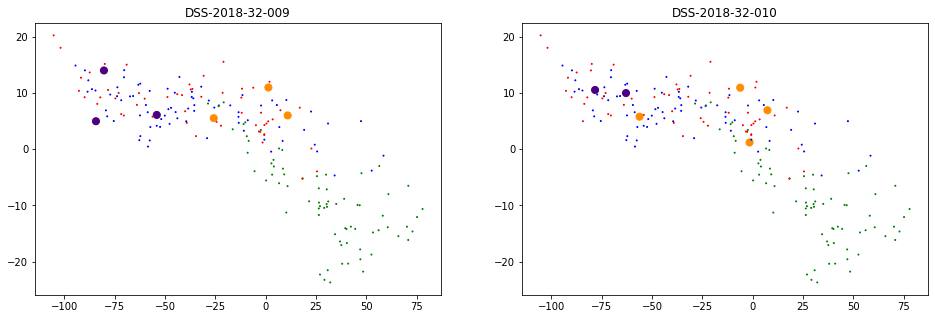

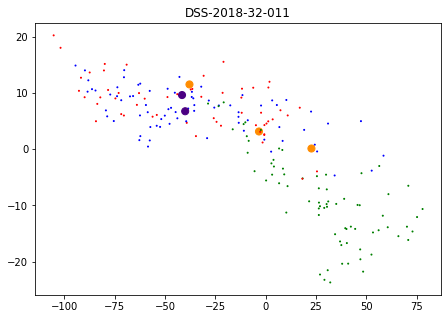

In [548]:
pltindex=1;

for i in dssdict["dss"]:
    sizelist=[];
    newcolors=[];
    
    for index in range(len(slideid)):
        
        
        if slideid[index].startswith(i+"_"):
            sizelist.append(50)
            
            location = slideid[index].split("_")[1];
            location=location[0];
            if location == "a":
                newcolors.append("indigo")
            elif location == "b":
                newcolors.append("darkorange")
        else:
            sizelist.append(1)
            newcolors.append(slidecolors[index])
    if pltindex==1:
        fig = plt.figure(figsize=(16, 5))
    ax = fig.add_subplot(120+pltindex)
    
    ax.set_title(i)
    
    ax.scatter(slidetsne[:, 0], slidetsne[:, 1],c=newcolors,s=sizelist)
    
    
    
    pltindex+=1;
    
    if pltindex>2:
        pltindex=1;

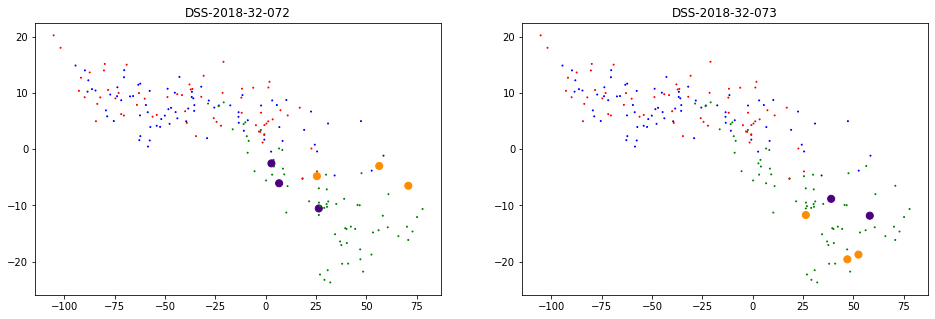

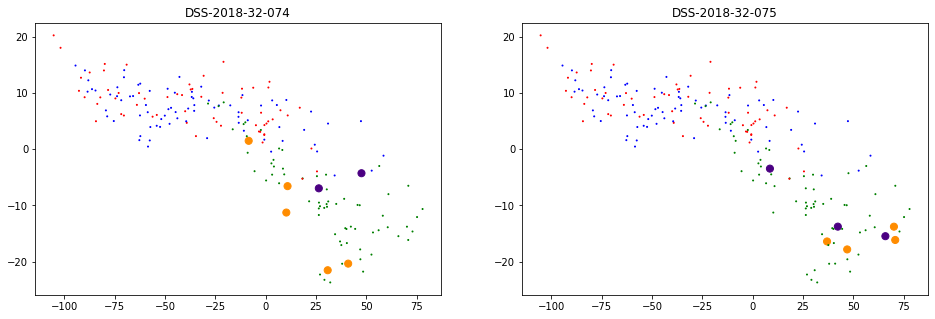

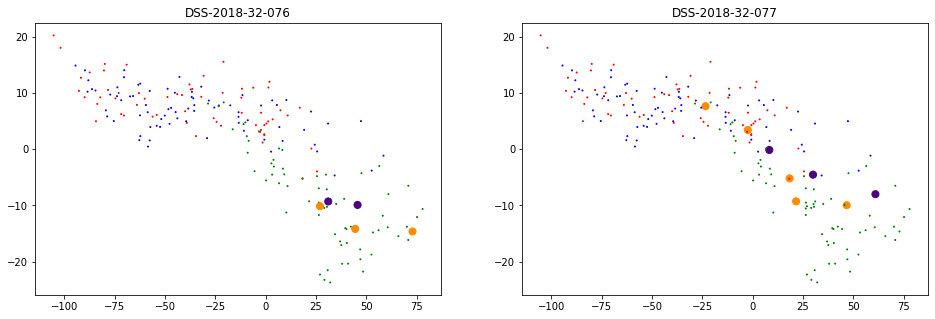

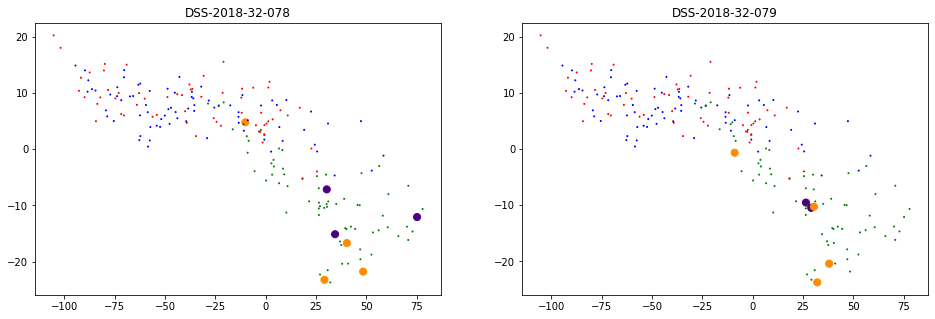

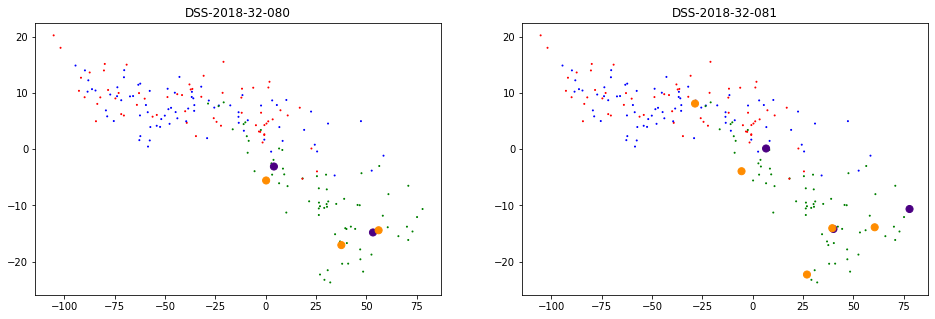

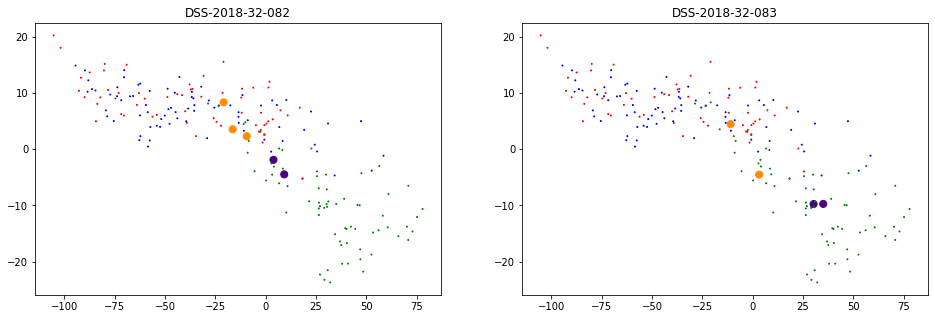

In [549]:
pltindex=1;

for i in dssdict["normal"]:
    sizelist=[];
    newcolors=[];
    
    for index in range(len(slideid)):
        
        
        if slideid[index].startswith(i+"_"):
            sizelist.append(50)
            
            location = slideid[index].split("_")[1];
            location=location[0];
            if location == "a":
                newcolors.append("indigo")
            elif location == "b":
                newcolors.append("darkorange")
        else:
            sizelist.append(1)
            newcolors.append(slidecolors[index])
    if pltindex==1:
        fig = plt.figure(figsize=(16, 5))
    ax = fig.add_subplot(120+pltindex)
    
    ax.set_title(i)
    
    ax.scatter(slidetsne[:, 0], slidetsne[:, 1],c=newcolors,s=sizelist)
    
    
    
    pltindex+=1;
    
    if pltindex>2:
        pltindex=1;

In [568]:
hc=sklearn.cluster.AgglomerativeClustering(n_clusters = 6,).fit_predict(slidetsne)

colordict=["blue","red","green","orange","yellow","steelblue","#aabbcc","#aabb00","#aa43cc","#6743cc"]
colorlabels=[]
for i in hc:
    colorlabels.append(colordict[i])

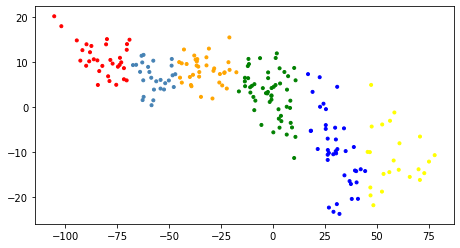

In [569]:
fig = plt.figure(figsize=(7.5, 4))

ax = fig.add_subplot(111)

ax.scatter(slidetsne[:, 0], slidetsne[:, 1],c=colorlabels,s=9)

In [570]:
#score 2.1

In [571]:
score21=[]
for i in range(len(slideid)):
    hcolor = colorlabels[i]
    if hcolor == "red":
        score21.append(4)
    elif hcolor == "steelblue":
        score21.append(3)
    elif hcolor == "orange":
        score21.append(2)
    elif hcolor == "green":
        score21.append(1)
    else:
        score21.append(0)

In [ ]:
#score 2.2

In [574]:
threshold = 0.3

In [573]:
right=np.max(slidetsne[:, 0])
left=np.min(slidetsne[:, 0])
top=np.max(slidetsne[:, 1])
bottom=np.min(slidetsne[:, 1])

In [576]:
xlength = right-left
ylength = top - bottom

In [586]:
levels=4

xlength2 =(1-threshold)*xlength
ylength2 =(1-threshold)*ylength

gapx=xlength2/4
gapy=ylength2/4


In [595]:
score22=[]
for i in range(len(slideid)):
    x=slidetsne[i][0];
    y=slidetsne[i][1];
    
    xvalue = 0;
    yvalue = 0;
    
    if x - left > (1-threshold)*xlength :
        xvalue = 0;
    else:
        temp =x-left;
        lv = temp/gapx
        xvalue = 4-(lv)
        
        
    if y- bottom < threshold*ylength:
        yvalue=0;
        
    else:
        temp = y-bottom-threshold*ylength
        lv = temp/gapy
        yvalue=(lv)
        
        
    score22.append(xvalue/2 + yvalue/2 )
        
    

In [644]:
scoredata_head = scoredata[0]

In [647]:
scoredata_head[23]

'gland_divid_mucosa'

In [654]:

myscore=[]

for i in scoredata[1:]:
    gdm = float(i[23])*10;
    score = 4-gdm;
    if score <0:
        score =0;
    
    myscore.append(score)
    
        
    